### Xarray remote data demo

This notebook demonstrates how the xpublish library (https://github.com/xarray-contrib/xpublish) can serve a chunked array from within a running notebook session. 

Getting this to work with neuroglancer required hacks to xpublish (see https://github.com/d-v-b/xpublish/tree/neuroglancer_compat)

In this demo, I will create a fake imaging dataset containing images of a moving disk. I will use a (bad) registration algorithm to attempt to align images of the disk to a reference image. Both the raw and aligned images will be served via xpublish, to be consumed and displayed chunk-wise by neuroglancer.

In [3]:
import xarray as xr
import numpy as np
import xpublish as xp
import dask.array as da
from dask import delayed

from numcodecs import GZip

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.figsize'] = (4,4)
plt.style.use('dark_background') # get plots to look nice in dark mode

import nest_asyncio
nest_asyncio.apply() # enable running the http server in the notebook

from skimage.registration import phase_cross_correlation # a medicore but fast image registration method
from scipy.ndimage.interpolation import shift 

import socket
ip_addr = socket.gethostbyname(socket.gethostname()) # get the IP address of my workstation

Define a function that creates an image of a noise-corrupted, blurred, shifted disk

In [4]:
def make_plane(shape, radius, shift_yx=(0,0)):
    from skimage.morphology import disk
    from scipy.ndimage.filters import gaussian_filter
    from scipy.ndimage.interpolation import shift
    
    assert 2 * radius < max(shape)
    disk_image = disk(radius)
    pw = np.subtract(shape, disk_image.shape) / 2
    pw = int(np.ceil(pw[0])), int(np.floor(pw[1]))
    full = np.pad(disk_image, pad_width=(pw, pw)).astype('uint8') * 50
    full += np.random.poisson(lam=50, size=full.shape).astype('uint8')
    full = gaussian_filter(full, sigma=(1))
    full = shift(full, shift=shift_yx, mode='reflect')
    return full

Test the `make_plane` function

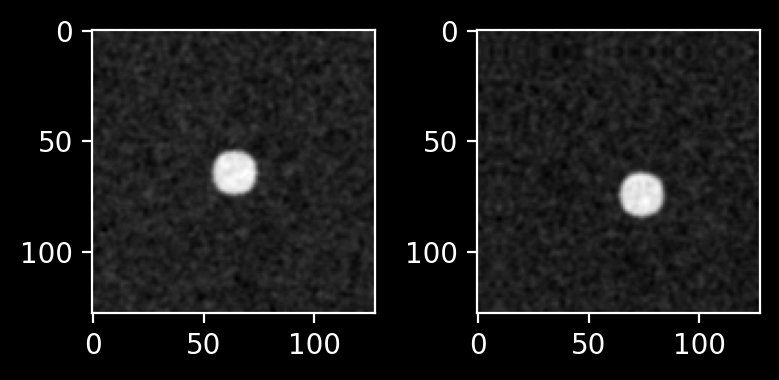

In [5]:
fig, axs = plt.subplots(ncols=2)
[ax.imshow(make_plane(shape=(128,128), radius=10, shift_yx=(10 * idx, 10 *idx)), cmap='gray') for idx, ax in enumerate(axs)];
plt.tight_layout()

Define the axes and shape of our dataset, and generate an array of random shifts to apply to the disk

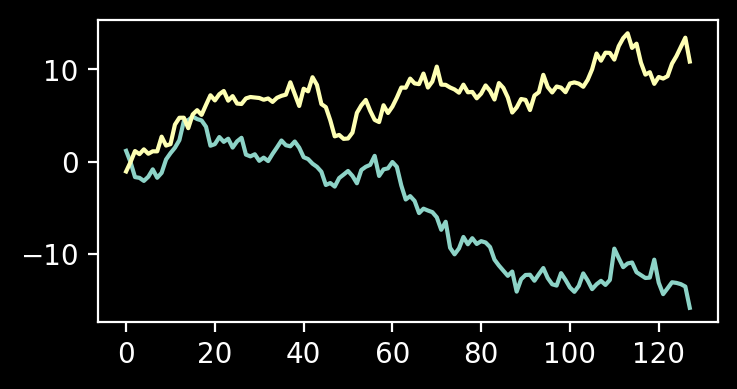

In [6]:
scale = 1
shape = {'t' : 128 * scale,  'y' : 128 * scale, 'x': 128 * scale}
radius = 10 * scale
shifts = np.cumsum(np.random.normal(size=(shape['t'], 2)), axis=0)
fig, axs = plt.subplots(figsize=(4,2))
axs.plot(shifts);

Make a dask array representing each image timepoint

In [7]:
make_plane_lazy = delayed(make_plane)
lazy_planes = [make_plane_lazy(shape=(shape['y'], shape['x']), radius=radius, shift_yx=shifts[t]) for t in range(shape['t'])]
sample = lazy_planes[0].compute()
data_raw = da.stack([da.from_delayed(plane, shape=sample.shape, dtype=sample.dtype) for plane in lazy_planes])

Make a DataArray with our Data

In [8]:
axes = shape.keys()
coords = {ax: np.arange(s) / 10 for ax,s in zip(axes, data_raw.shape)}
data_raw_xr = xr.DataArray(data=data_raw, coords=coords, dims=axes)

In [9]:
data_raw_xr

,Array,Chunk
Bytes,2.10 MB,16.38 kB
Shape,"(128, 128, 128)","(1, 128, 128)"
Count,384 Tasks,128 Chunks
Type,uint8,numpy.ndarray


Next we use the first image in the sequence as a reference and estimate the translation of each subsequent plane relative to the reference. These translation estimates are used to transform the raw data, resulting in a new DataArray.

In [10]:
putative_shifts = [phase_cross_correlation(data_raw[0], data_raw[idx])[0] for idx in range(data_raw.shape[0])]
data_tx = da.stack([da.from_delayed(delayed(shift)(d, s), shape=sample.shape, dtype=sample.dtype) for d,s in zip(data_raw, shifts)])
data_tx_xr = xr.DataArray(data=data_tx, coords=coords, dims=axes)

Create an xarray Dataset object (basically a k:v store of DataArrays) and use xpublish to serve chunks of our datasets over HTTP:

In [ ]:
data_raw_xr.encoding = {"compressor": {"id": "gzip","level": -1}}
data_tx_xr.encoding = {"compressor": {"id": "gzip","level": -1}}

dataset = xr.Dataset({'data_raw' : data_raw_xr, 'data_tx' : data_tx_xr})

print('Neuroglancer endpoints:')
[print(f'zarr://http://{ip_addr}:9000/{k}') for k in dataset.keys()]

# start the HTTP server
xp.Rest(dataset).serve()